### Clean and Process JHU Methylation Data

NOTE: Before running, __go to the last cell__ and run that first.

This is part of a workflow that takes a paired-set of files from the Genomic Data Commons along with an annotation file of the Illumina 450k bead chip array. This array generates a comprehensive genome-wide profile of human DNA methylation. 

DNA methylation plays a significant role in the epigenetic regulation of gene expression, development and genetic imprinting in vertebrates. 

In [2]:
import os
import pandas as pd

In [3]:
LONG_RUN = True # set to 'False' to skip long-running processes. 

base           = '../../data/johnshopkins-data/'
pickle_base    = '../../data/pickle/'
directory      = 'BRCA-PAIRED/'
tissue         = 'BRCA'
minor          = 'BH'
major          = 'A1EN'

file_str_norm  = 'TCGA-{minor}-{major}-{tissue}-{status}.{ext}'.format(minor=minor,
                                                                major=major,
                                                                tissue=tissue,
                                                                status='Normal', 
                                                                ext='xlsx')
file_str_tumr  = 'TCGA-{minor}-{major}-{tissue}-{status}.{ext}'.format(minor=minor,
                                                                major=major,
                                                                tissue=tissue,
                                                                status='Tumor', 
                                                                ext='xlsx')
file_str_picl  = 'TCGA-{minor}-{major}-{tissue}.{ext}'.format(minor=minor,
                                                                major=major,
                                                                tissue=tissue,
                                                                ext='pkl')

anno_str       = 'Illumina-450k-Anno.{rev}.{ext}'.format(rev='hg19',ext='pkl')

tumor          = '{t}_tumor'.format(t=tissue) 
normal         = '{t}_normal'.format(t=tissue)
methylation    = '{t}_methyl'.format(t=tissue)

print(file_str_picl)

TCGA-BH-A1EN-BRCA.pkl


Read in a pair of files - normal methyl values versus tumor methyl values - from the local filesystem. All data files are from https://portal.gdc.cancer.gov/. The Excel format is about 1/3 the size of the raw text files.

In [4]:
if LONG_RUN:
    normal_file   =  pd.read_excel(base + directory + file_str_norm)
    tumor_file    =  pd.read_excel(base + directory + file_str_tumr)
else:
    pass # load object.

Using the format above allows loading different datasets and running them without altering files paths, etc. 

In [5]:
normal_file.head() # the raw data contains NaNs...

,Composite Element REF,Beta_value,Chromosome,Start,End,Gene_Symbol,Gene_Type,Transcript_ID,Position_to_TSS,CGI_Coordinate,Feature_Type
0,cg00000029,0.194329,chr16,53434200,53434201,RBL2;RBL2;RBL2,protein_coding;protein_coding;protein_coding,ENST00000262133.9;ENST00000544405.5;ENST000005...,-221;-1420;222,CGI:chr16:53434489-53435297,N_Shore
1,cg00000108,NaN,chr3,37417715,37417716,C3orf35;C3orf35;C3orf35;C3orf35;C3orf35;C3orf3...,lincRNA;lincRNA;lincRNA;lincRNA;lincRNA;lincRN...,ENST00000328376.8;ENST00000332506.6;ENST000004...,18552;18552;6505;31445;18143;447;18552;18552,CGI:chr3:37451927-37453047,.
2,cg00000109,NaN,chr3,172198247,172198248,FNDC3B;FNDC3B;FNDC3B;FNDC3B;FNDC3B;FNDC3B,protein_coding;protein_coding;protein_coding;p...,ENST00000336824.7;ENST00000415807.5;ENST000004...,157692;158618;151333;71272;158587;71273,CGI:chr3:172039703-172040934,.
3,cg00000165,0.147221,chr1,90729117,90729118,.,.,.,.,CGI:chr1:90724932-90727247,S_Shore
4,cg00000236,0.885305,chr8,42405776,42405777,VDAC3,protein_coding,ENST00000022615.7,13872,CGI:chr8:42410918-42411241,.


The files from JHU are 'TCGA Level 3 DNA methylation data' (hg19-based). GDC does liftover to convert the Illumina 450k probes to GRCh38. To understand how GDC does this see: [GDC](https://docs.gdc.cancer.gov/Data/Bioinformatics_Pipelines/Methylation_LO_Pipeline/). An explanation of the above rows and columns...

| Field                 | Definition                                                                           |
|-----------------------|--------------------------------------------------------------------------------------|
| Composite Element REF | A unique ID for the array probe associated with a CpG site.                          |
| Beta_value            | Ratio between the methylated array intensity and total array intensity.              |
| Chromosome            | The chromosome in which the probe binding site is located.                           |
| Start                 | The start of the CpG site on the chromosome. ()                                        |
| End                   | The end of the CpG site on the chromosome. ()                                          |
| Gene_Symbol           | Genes associated with the CpG site.                                                  |
| Gene_Type             | A classification for each gene (e.g. protein coding, miRNA, pseudogene).             |
| Transcript_ID         | Ensembl transcript IDs for each transcript associated with the genes detailed above  |
| Position_to_TSS       | Distance in base pairs from the CpG site to each associated transcript's start site. |
| CGI_Coordinate        | The start and end coordinates of the CpG island associated with the CpG site.        |
| Feature_Type          | The position of the CpG site in reference to the island (Island, N_Shore etc.).      |

The next two cells create a pre-edited methyl dataframe that is ultimately merged into a single object and saved to the file system.  

In [6]:
# 1. Create an empty Pandas dataframe with columns we want to save from GDC.
# 2. Create column slices of the GDC data to save. 
# 3. Clean up some of the columns with bad values (w/o loosing key reference to ID). 
# 4. Populate the dataframe.

# 1. ------- create df headings
_methyl_df = pd.DataFrame(columns = ['ID_REF',
                                    'Location',
                                    'CGI_Coordinate',
                                    'Gene_Symbol',
                                    'Gene_Type', 
                                    'Beta_Tumor', 
                                    'Beta_Normal',])
# 2. ------- slice columns
ID_REF    = normal_file['Composite Element REF']
_location = normal_file['End']
_cgi_cord = normal_file['CGI_Coordinate']
_N_BETA   = normal_file['Beta_value'] # column slices from file
_T_BETA   = tumor_file['Beta_value']

# 3. ------- clean up bad rows
_cgi_cord = [c[4:] for c in _cgi_cord]

_gsymbol      = normal_file['Gene_Symbol']
split_symbol  = _gsymbol.str.split(';')
split_symbol  = [sym[0] if type(sym) != float else '.' for sym in split_symbol]
_gsymbol      = pd.Series( (s for s in split_symbol) )

_gtype        = normal_file['Gene_Type']
split_gtype   = _gtype.str.split(';')
split_gtype   = [sym[0] if type(sym) != float else '.' for sym in split_gtype]
_gtype        = pd.Series( (s for s in split_gtype) )

# 4. ------- populate dataframe
_methyl_df['ID_REF']          =  ID_REF  # populate dataframe 
_methyl_df['Location']        =  _location
_methyl_df['CGI_Coordinate']  = _cgi_cord
_methyl_df['Gene_Symbol']     = _gsymbol
_methyl_df['Gene_Type']       = _gtype
_methyl_df['Beta_Normal']     = _N_BETA
_methyl_df['Beta_Tumor']      = _T_BETA

In [7]:
print(len(_methyl_df))
_methyl_df.head()

485577


,ID_REF,Location,CGI_Coordinate,Gene_Symbol,Gene_Type,Beta_Tumor,Beta_Normal
0,cg00000029,53434201,chr16:53434489-53435297,RBL2,protein_coding,0.119561,0.194329
1,cg00000108,37417716,chr3:37451927-37453047,C3orf35,lincRNA,NaN,NaN
2,cg00000109,172198248,chr3:172039703-172040934,FNDC3B,protein_coding,NaN,NaN
3,cg00000165,90729118,chr1:90724932-90727247,.,.,0.616919,0.147221
4,cg00000236,42405777,chr8:42410918-42411241,VDAC3,protein_coding,0.927754,0.885305


In [8]:
_methyl_df = _methyl_df.dropna(how='any') 

Dropping NaNs leaves us with a bit less (~390-400k) that the original 485k. The number of NaNs will vary. 

In [9]:
print(len(_methyl_df))
_methyl_df.head()

395373


,ID_REF,Location,CGI_Coordinate,Gene_Symbol,Gene_Type,Beta_Tumor,Beta_Normal
0,cg00000029,53434201,chr16:53434489-53435297,RBL2,protein_coding,0.119561,0.194329
3,cg00000165,90729118,chr1:90724932-90727247,.,.,0.616919,0.147221
4,cg00000236,42405777,chr8:42410918-42411241,VDAC3,protein_coding,0.927754,0.885305
5,cg00000289,68874423,chr14:68874710-68875103,ACTN1,protein_coding,0.784276,0.722705
6,cg00000292,28878780,chr16:28879633-28880547,ATP2A1,protein_coding,0.838242,0.634605


The following is sourced from an external file 'annotate_450k.py'. This object helps represent an Illumina 450k probe and will allow us to manipulate probes as arbitrary groups.  

The following creates an annotation object from the Illumina 450k manifest. If the object was created and is local it will load it instead. 

In [10]:
print (pickle_base + anno_str)

../../data/pickle/Illumina-450k-Anno.hg19.pkl


In [11]:
exists_annotate   = os.path.isfile(pickle_base + anno_str)

if exists_annotate: # load file
    annotate = load_obj(anno_str[:-4])
else:
    annotate = Annotate_450k() # create annotation object containing all probes
    save_obj(annotate, anno_str[:-4])


loading Illumina-450k-Anno.hg19 ...


In [12]:
annotate.get_probe('cg00035864').hg19_cord # return a single probe, w/ hg19 coordinates.

8553009

At this point we have two big data structures: an annotation object which describes the 450k probes 
(annotate); and a methylation object for each cancer type (i.e. LUAD_methyl_df, GBM_methyl_df, etc.)
We want to merge these into one object but need to clean up the SNPs first.  

In [13]:
# size of annotate before cleaning...
annotate.get_number() 

482421

In [14]:
# after dropping SNPs...
annotate.remove_snp_probes()

Change the index label to be ID_REF...

In [15]:
_methyl_df = _methyl_df.set_index('ID_REF') # can only run this one time. 
_methyl_df.head(n=5)

,Location,CGI_Coordinate,Gene_Symbol,Gene_Type,Beta_Tumor,Beta_Normal
ID_REF,,,,,,
cg00000029,53434201,chr16:53434489-53435297,RBL2,protein_coding,0.119561,0.194329
cg00000165,90729118,chr1:90724932-90727247,.,.,0.616919,0.147221
cg00000236,42405777,chr8:42410918-42411241,VDAC3,protein_coding,0.927754,0.885305
cg00000289,68874423,chr14:68874710-68875103,ACTN1,protein_coding,0.784276,0.722705
cg00000292,28878780,chr16:28879633-28880547,ATP2A1,protein_coding,0.838242,0.634605


In [16]:
# size of LUAD methylation object and annotate object after cleaning...
len(_methyl_df), annotate.get_number()

(395373, 210294)

We want the REF_IDs (from annotate) to correspond to REF_IDs in the methyl_df object. For this we need to find the intersection of REF_IDs in annotate and methyl_df. We accomplish this using Python sets. The following shows an example. 

In [17]:
# find common members among two sets of unique elements
set1 = set([1, 2, 3 ,4 ,5 ,6 ,7 ,8 ,9, 10, 11, 12, 13, 14])
set2 = set([7 ,8 ,9, 10, 11, 12, 13, 14])
dff = set1.intersection(set2)
dff 

{7, 8, 9, 10, 11, 12, 13, 14}

In [18]:
# same as above, applied to the REF_IDs

m_set = set(list(_methyl_df.index))      # unique methyl_df members
a_set = set(list(annotate.probe.keys())) # unique annotate members

m_a_intersect = sorted(m_set.intersection(a_set)) # sort the resulting intersection set

len(m_a_intersect)

183863

The difference in size between LUAD_methyl_df and annotate - and the intersection between them - reflects that some probes in the former are removed as SNPs or missing values from the latter. The intersection is what we end up with: a fully-annotated probe set for which we have methylation beta-values. Before merging, a probe (without methylation data) has the following attributes:

In [19]:
cg00035864 = annotate.get_probe('cg00035864')
[a for a in dir(cg00035864) if not a.startswith('__')]

['chr',
 'feature',
 'gene',
 'hg19_cord',
 'id',
 'name',
 'refseq',
 'seq',
 'strand',
 'tour']

| Field                       | Definition                                                 |
|-----------------------------|------------------------------------------------------------|
| AddressA_ID                 | Address ID for the probe used for both A and B alleles.    |
| AlleleA_ProbeSeq            | Sequence of probe identified in AddressA_ID column.        |
| Forward_Sequence            | Plus (+) strand (HapMap) sequence (5'-3') flanking the CG. |
| CHR (__chr__)                 | Chromosome containing the CpG (Build 37).                  |
| MAPINFO                     | Chromosomal coordinates of the CpG (Build 37).             |
| SourceSeq                   | Genomic sequence prior to bisulfite conversion.            |
| Strand                      | F Strand = (+) and R = (-).                                |
| UCSC_RefGene_Name           | Target gene name[s] from UCSC, w/ splice variants.         |
| UCSC_RefGene_Accession      | UCSC ACC's of target transcripts, in order w/ transcripts. |
| UCSC_RefGene_Group          | Gene region of CpG position, from UCSC.                    |
| UCSC_CpG_Islands_Name       | Chromosomal coordinates of the CpG Island, from UCSC.      |
| Relation_to_UCSC_CpG_Island | The location of the CpG relative to a CpG island.          |

A df of the final methyl set. 'm_a_intersect' is a list of indexes.

In [20]:
methyl = _methyl_df.loc[m_a_intersect]
methyl.head()

,Location,CGI_Coordinate,Gene_Symbol,Gene_Type,Beta_Tumor,Beta_Normal
ID_REF,,,,,,
cg00000029,53434201,chr16:53434489-53435297,RBL2,protein_coding,0.119561,0.194329
cg00000165,90729118,chr1:90724932-90727247,.,.,0.616919,0.147221
cg00000289,68874423,chr14:68874710-68875103,ACTN1,protein_coding,0.784276,0.722705
cg00000363,230425048,chr1:230425357-230426956,PGBD5,protein_coding,0.825820,0.226654
cg00000658,137103473,chr9:137103394-137103596,MAN1B1,protein_coding,0.900696,0.865487


Now all elements in methyl are also contained in annotate. However, there's still a difference in the number of elements in each object. Some found in annotate are not found in methyl.

In [21]:
len(annotate.probe), len(methyl)

(210294, 183863)

Using set operations again (this time, difference) we can find and remove these...

In [22]:
m_set_two = set(list(methyl.index)) # unique methyl_set members
a_set_two = set(list(annotate.probe.keys())) # unique annotate members
m_a_difference_two = sorted(a_set_two.difference(m_set_two)) # sort the difference

for item in m_a_difference_two:
    try:
        annotate.probe.pop(item, None)
    except KeyError:
        pass
    
len(annotate.probe), len(methyl)

(183863, 183863)

Finally, we have two objects cleaned and aligned such that they can be merged. We do this by setting attributes on a new dict object containing only filtered probes from the annotate object along with methyl values for matching probe REF_IDs in the methyl object.   

In [23]:
#LONG_RUN = False 

methyl_probe_dict = {}

if LONG_RUN:
    for index, row in methyl.iterrows(): # annotate and methyl have the same number of rows...
        methyl_probe_dict[index] = annotate.probe.get(index) # so these indexes will match...
        setattr(methyl_probe_dict[index], 'hg38_cord', row[0])
        setattr(methyl_probe_dict[index], 'GDC_CGI_Coordinate', row[1])
        setattr(methyl_probe_dict[index], 'GDC_gene', row[2])
        setattr(methyl_probe_dict[index], 'GDC_gene_type', row[3])
        setattr(methyl_probe_dict[index], 'Beta_Tumor', row[4])
        setattr(methyl_probe_dict[index], 'Beta_Normal', row[5])
else:    
    for index, row in methyl.head(5).iterrows():
        methyl_probe_dict[index] = annotate.probe.get(index) # so these indexes will match...
        setattr(methyl_probe_dict[index], 'hg38_cord', row[0])
        setattr(methyl_probe_dict[index], 'GDC_CGI_Coordinate', row[1])
        setattr(methyl_probe_dict[index], 'GDC_gene', row[2])
        setattr(methyl_probe_dict[index], 'GDC_gene_type', row[3])
        setattr(methyl_probe_dict[index], 'Beta_Tumor', row[4])
        setattr(methyl_probe_dict[index], 'Beta_Normal', row[5])
        
len(methyl_probe_dict)

183863

In [24]:
cg00000029 = methyl_probe_dict['cg00000029']
attribute_list = [a for a in dir(cg00000029) if not a.startswith('__')]
print(attribute_list)

['Beta_Normal', 'Beta_Tumor', 'GDC_CGI_Coordinate', 'GDC_gene', 'GDC_gene_type', 'chr', 'feature', 'gene', 'hg19_cord', 'hg38_cord', 'id', 'name', 'refseq', 'seq', 'strand', 'tour']


Create a boxplot of the methylation values to see how they stack up...

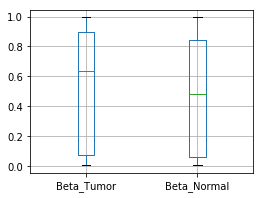

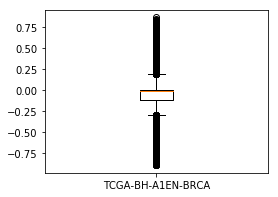

In [26]:
import matplotlib.pyplot as plt 
plt.close('all')

plt.figure(figsize=(4, 3))
_methyl_df.boxplot(column=['Beta_Tumor', 'Beta_Normal'])

legend_str = normal + ' - ' + tumor 
# Boxplot of the difference
plt.figure(figsize=(4, 3))
plt.boxplot(_methyl_df['Beta_Normal'] - _methyl_df['Beta_Tumor'])
plt.xticks((1, ), (file_str_picl[:-4], ))
#plt.xticks((1, ), (legend_str, ))

plt.show() # plot all data from a paired JHU dataset

Finally, we want to save things so we don't have to re-build from scratch. The paths where things are saved are: 

In [27]:
print(pickle_base + file_str_picl)
print(pickle_base + anno_str)

../../data/pickle/TCGA-BH-A1EN-BRCA.pkl
../../data/pickle/Illumina-450k-Anno.hg19.pkl


In [92]:
exists_methyl     = os.path.isfile(pickle_base + file_str_picl)
exists_annotate   = os.path.isfile(pickle_base + anno_str)

if exists_methyl:
    pass
else:
    # create file
    save_obj(methyl_probe_dict, file_str_picl[:-4])

if exists_annotate:
    pass
    #annotate = load_obj(anno_str[:-4]) # this is the full annotation, with SNPs, minus our additions. 
else:
    pass

saving TCGA-BH-A1EN-BRCA ...


In [63]:
methyl_probe_dict = {}
methyl_probe_dict = load_obj(file_str_picl[:-4]) # let's see if that worked. 

loading TCGA-E2-A1IO-BRCA ...


In [28]:
probe = methyl_probe_dict['cg00000029']

try:
    print(file_str_picl[:-4])
    print()
    
    print ('Probe ID (Illumina/GDC): {id}'.format(id=probe.id))
    print ('Probe hg19_cord (Illumina): {hg19_cord}'.format(hg19_cord=probe.hg19_cord))
    print ('Probe hg38_cord (GDC): {hg38_cord}'.format(hg38_cord=probe.hg38_cord))
    print ('CpG Island (GDC): {GDC_CGI_Coordinate}'.format(GDC_CGI_Coordinate=probe.GDC_CGI_Coordinate))
    print ('Relation to CpG (Illumina): {tour}'.format(tour=probe.tour))
    print ('CpG Feature (Illumina): {feature}'.format(feature=probe.feature[0]))
    print ('Gene (Illumina/GDC): {gene}'.format(gene=probe.GDC_gene))
    print ('Gene Function (GDC): {gene_type}'.format(gene_type=probe.GDC_gene_type))
    print()
    print ('Tumor Methylation Beta (GDC): {tumor}'.format(tumor=probe.Beta_Tumor))
    print ('Normal Methylation Beta (GDC): {normal}'.format(normal=probe.Beta_Normal))
    print()
except AttributeError:
    print('Try another probe ...')
    

TCGA-BH-A1EN-BRCA

Probe ID (Illumina/GDC): cg00000029
Probe hg19_cord (Illumina): 53468112
Probe hg38_cord (GDC): 53434201
CpG Island (GDC): chr16:53434489-53435297
Relation to CpG (Illumina): N_Shore
CpG Feature (Illumina): TSS1500
Gene (Illumina/GDC): RBL2
Gene Function (GDC): protein_coding

Tumor Methylation Beta (GDC): 0.119561150623075
Normal Methylation Beta (GDC): 0.194329270247097



In [1]:
# %load '../methylator/annotation/annotate_450k.py'
import os

class Probe:
    """
    Holds Illumina 450k probe info for a single CpG site.
    """
    def __init__(self):
        self.id = None
        self.seq = None
        self.name = None
        self.chr = None
        self.hg19_cord = None
        self.strand = None
        self.gene = None
        self.refseq = None
        self.tour = None
        self.feature = None
        
class Interval:
    """
    Define a genomic interval by chromsome and strand orientation.
    """
    def __init__(self, chromosome, start, end, strand):
        self.chr = chromosome
        self.start = start
        self.end = end
        self.strand = strand

class Feature:
    """
    Define a Probe feature.
    """
    BODY = "Body"
    TSS200 = "TSS200"
    TSS1500 = "TSS1500"
    UTR5 = "5'UTR"
    UTR3 = "3'UTR"
    EXON = "Exon"

class CpG_location:
    """
    Defines a CpG location.
    """
    ISLAND = "Island"
    NSHORE = "N_Shore"
    SSHORE = "S_Shore"
    NSHELF = "N_Shelf"
    SSHELF = "S_Shelf"
    
class SNP:
    """
    Defines the SNPs in probes. Used to filter probes.
    """

    def __init__(self):
        self.probeid = None
        self.snpid = None
    
class Annotate_450k:
    """
    Parse and hold information about Illumina probes.
    """

    def __init__(self):        
        for i in open(anno_file, mode="r"):
            self.ann = os.path.join("../../data/", i.strip("\n").strip("\r"))

        self.probe = {}
        self.__run__()

    def __run__(self):
        """
        A static function to setup the Probe classes.
        """
        for i in open(self.ann, mode="r"):
            if i.startswith("cg"):
                data = i.split(",")
                # Assign probe information.
                new_probe = Probe()
                new_probe.id = data[0]                 # ID
                new_probe.name = data[1]               # name
                new_probe.seq = data[13]               # sequence prior to bi-sulfite conv.
                new_probe.chr = str(data[11])          # chromosome
                new_probe.hg19_cord = int(data[12])    # chromosomal coordinates of the CpG.
                new_probe.strand = data[16]            # strand
                new_probe.gene = data[21].split(";")   # UCSC_RefGene_Name
                new_probe.refseq = data[22]            # UCSC_RefGene_Accession
                features = data[23].split(";")         # UCSC_RefGene_Group
                list_features = []
                for i in features:
                    if i not in list_features:
                        list_features.append(i)

                new_probe.feature = list_features

                new_probe.tour = data[25]              # Relation_to_UCSC_CpG_Island
                newcpg = {new_probe.id: new_probe}
                self.probe.update(newcpg)

    def get_number(self):
        """
        Return total number of probes.
        """
        number = 0
        for probe_id in self.probe.keys():
            number += 1

        return number

    def get_probe(self, probe_id):
        """
        Return probe info associated with an reference.
        """
        try:
            probe = self.probe[probe_id]
        except Exception as ex:
            probe = None
            print("WARNING: No probe with ref-id of %s found." % probe_id)
        return probe

    def remove_snp_probes(self):
        """
        Removes all SNPs associated with probes.
        """
        snp_list = []
        snp_file = open("../../data/humanmethylation450_dbsnp137.snpupdate.table.v2.sorted.txt", "r")
        for line in snp_file:
            if line.startswith("cg"):
                line = line.strip("\n").strip("\r").split("\t")
                new_snp = SNP()
                new_snp.probeid = line[0]
                new_snp.snpid = line[1]
                snp_list.append(new_snp)

        for snp in snp_list:
            self.probe.pop(snp.probeid)

anno_file = os.path.abspath("../../data/config.ini") # Illumina probe manifest. 

import _pickle as pickle

def save_obj(obj, name):
    print('saving ' + name + ' ...')
    with open('../../data/pickle/'+ name + '.pkl', 'wb+') as f:
        pickle.dump(obj, f)
        
def load_obj(name):
    print('loading ' + name + ' ...')
    with open('../../data/pickle/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)